# Unseen Object Instance Segmentation

In [1]:
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0" # TODO: Change this if you have more than 1 GPU

import sys
import json
from time import time
import glob

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio

# My libraries. Ugly hack to import from sister directory
import src.data_augmentation as data_augmentation
import src.segmentation as segmentation
import src.evaluation as evaluation
import src.util.utilities as util_
import src.util.flowlib as flowlib

## Depth Seeding Network Parameters

In [2]:
dsn_config = {
    
    # Sizes
    'feature_dim' : 64, # 32 would be normal

    # Mean Shift parameters (for 3D voting)
    'max_GMS_iters' : 10, 
    'epsilon' : 0.05, # Connected Components parameter
    'sigma' : 0.02, # Gaussian bandwidth parameter
    'num_seeds' : 200, # Used for MeanShift, but not BlurringMeanShift
    'subsample_factor' : 5,
    
    # Misc
    'min_pixels_thresh' : 500,
    'tau' : 15.,
    
}

## Region Refinement Network parameters

In [3]:
rrn_config = {
    
    # Sizes
    'feature_dim' : 64, # 32 would be normal
    'img_H' : 224,
    'img_W' : 224,
    
    # architecture parameters
    'use_coordconv' : False,
    
}

# UOIS-Net-3D Parameters

In [4]:
uois3d_config = {
    
    # Padding for RGB Refinement Network
    'padding_percentage' : 0.25,
    
    # Open/Close Morphology for IMP (Initial Mask Processing) module
    'use_open_close_morphology' : True,
    'open_close_morphology_ksize' : 9,
    
    # Largest Connected Component for IMP module
    'use_largest_connected_component' : True,
    
}

In [5]:
#checkpoint_dir = '/home/chrisxie/projects/uois/checkpoints/' # TODO: change this to directory of downloaded models
checkpoint_dir = '/home/tpatten/Code/uois/checkpoints/' # TODO: change this to directory of downloaded models
dsn_filename = checkpoint_dir + 'DepthSeedingNetwork_3D_TOD_checkpoint.pth'
rrn_filename = checkpoint_dir + 'RRN_OID_checkpoint.pth'
uois3d_config['final_close_morphology'] = 'TableTop_v5' in rrn_filename
uois_net_3d = segmentation.UOISNet3D(uois3d_config, 
                                     dsn_filename,
                                     dsn_config,
                                     rrn_filename,
                                     rrn_config
                                    )

Let's use 1 GPUs for DSN!
Loaded DSNWrapper model
Let's use 1 GPUs for RRN!
Loaded RRNWrapper model


## Run on example OSD/OCID images

We provide a few [OSD](https://www.acin.tuwien.ac.at/en/vision-for-robotics/software-tools/osd/) and [OCID](https://www.acin.tuwien.ac.at/en/vision-for-robotics/software-tools/object-clutter-indoor-dataset/) images and run the network on them. Evaluation metrics are shown for each of the images.

In [10]:
example_images_dir = os.path.abspath('.') + '/example_ycbv'

rgb_image_files = sorted(glob.glob(example_images_dir + '/rgb/*.png'))
N = len(rgb_image_files)
# [1066.778, 0.0,      312.9869,
#  0.0,      1067.487, 241.3109,
#  0.0,      0.0,      1.0]
cam_k = {'fx': 1066.778, 'fy': 1067.487,
         'x_offset': 312.9869, 'y_offset': 241.3109,
         'img_height': 480, 'img_width': 640}
depth_scale = 0.1

rgb_imgs = np.zeros((N, 480, 640, 3), dtype=np.float32)
xyz_imgs = np.zeros((N, 480, 640, 3), dtype=np.float32)

for i, img_file in enumerate(rgb_image_files):
    # d = np.load(img_file, allow_pickle=True, encoding='bytes').item()
    
    # RGB
    rgb_img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB).astype(np.float32)
    rgb_imgs[i] = data_augmentation.standardize_image(rgb_img)

    # XYZ
    dep_file = img_file.replace('/rgb/', '/depth/')
    #depth_img = cv2.imread(dep_file, cv2.IMREAD_ANYDEPTH)
    depth_img = imageio.imread(dep_file).astype(np.float32)
    depth_img = (depth_img / 1000. * depth_scale).astype(np.float32)
    xyz_img = util_.compute_xyz(depth_img, cam_k)
    xyz_imgs[i] = xyz_img
    
batch = {
    'rgb' : data_augmentation.array_to_tensor(rgb_imgs),
    'xyz' : data_augmentation.array_to_tensor(xyz_imgs),
}

In [11]:
print("Number of images: {0}".format(N))

### Compute segmentation masks ###
st_time = time()
fg_masks, center_offsets, initial_masks, seg_masks = uois_net_3d.run_on_batch(batch)
total_time = time() - st_time
print('Total time taken for Segmentation: {0} seconds'.format(round(total_time, 3)))
print('FPS: {0}'.format(round(N / total_time,3)))

# Get results in numpy
seg_masks = seg_masks.cpu().numpy()
fg_masks = fg_masks.cpu().numpy()
center_offsets = center_offsets.cpu().numpy().transpose(0,2,3,1)
initial_masks = initial_masks.cpu().numpy()

Number of images: 3
Total time taken for Segmentation: 0.575 seconds
FPS: 5.219


0 255 (480, 640, 3)
0.0 2.8799999 (480, 640)
0 255 (480, 640, 3)
0.0 2.8799999 (480, 640)
0 255 (480, 640, 3)
0.0 2.872 (480, 640)


'\n0 253 (480, 640, 3)\n0.0 4.142 (480, 640)\n0 254 (480, 640, 3)\n0.0 4.5210004 (480, 640)\n0 255 (480, 640, 3)\n0.0 1.78575 (480, 640)\n0 255 (480, 640, 3)\n0.0 1.731 (480, 640)\n'

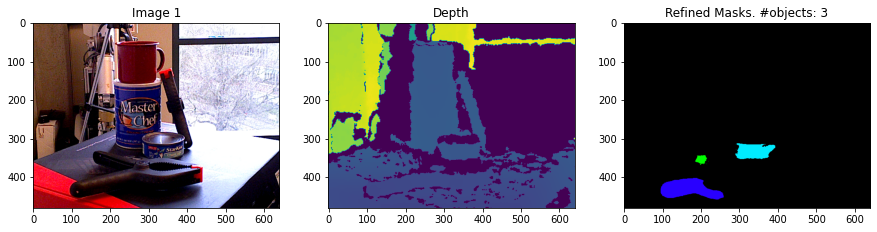

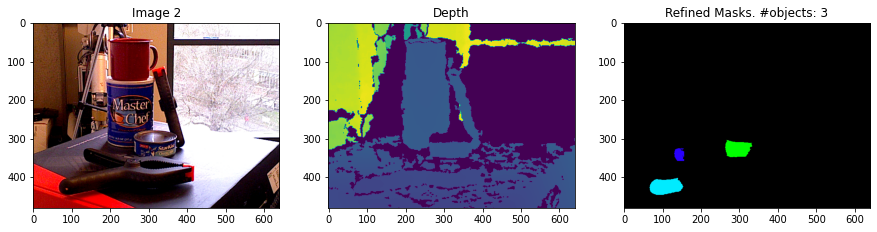

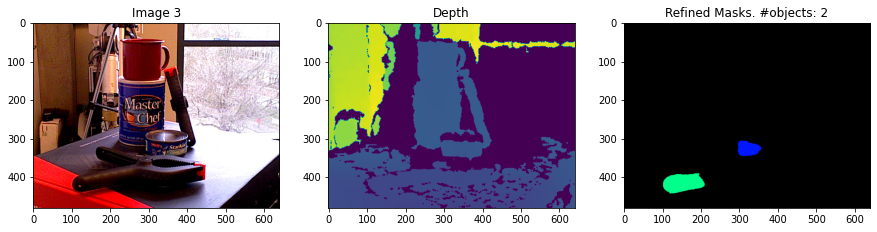

In [12]:
rgb_imgs = util_.torch_to_numpy(batch['rgb'].cpu(), is_standardized_image=True)
total_subplots = 6

fig_index = 1
for i in range(N):
    
    num_objs = np.unique(seg_masks[i,...]).max() + 1
    
    rgb = rgb_imgs[i].astype(np.uint8)
    
    print(rgb.min(), rgb.max(), rgb.shape)
    
    depth = xyz_imgs[i,...,2]
    
    print(depth.min(), depth.max(), depth.shape)
    
    seg_mask_plot = util_.get_color_mask(seg_masks[i,...], nc=num_objs)
    
    images = [rgb, depth, seg_mask_plot]
    titles = [f'Image {i+1}', 'Depth',
              f"Refined Masks. #objects: {np.unique(seg_masks[i,...]).shape[0]-1}",
             ]
    util_.subplotter(images, titles, fig_num=i+1)
    
'''
0 253 (480, 640, 3)
0.0 4.142 (480, 640)
0 254 (480, 640, 3)
0.0 4.5210004 (480, 640)
0 255 (480, 640, 3)
0.0 1.78575 (480, 640)
0 255 (480, 640, 3)
0.0 1.731 (480, 640)
'''